In [1]:
import os
import glob
from google.colab import drive
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras import layers, models
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
def compute_saliency_map(model, image_tensor):
    with tf.GradientTape() as tape:
        tape.watch(image_tensor)  # Watch the input image
        predictions = model(image_tensor)  # Forward pass
        class_idx = tf.argmax(predictions[0])  # Get the highest probability class
        loss = predictions[:, class_idx]  # Loss is the predicted probability of that class

    # Compute gradients of the output class w.r.t. the input image
    gradients = tape.gradient(loss, image_tensor)

    # Take the maximum absolute value across the color channels
    saliency = tf.reduce_max(tf.abs(gradients), axis=-1)[0]

    return saliency.numpy()


In [24]:
from tensorflow.keras.applications import Xception

base_model = tf.keras.applications.ResNet50(weights="imagenet", include_top=True)

model = Xception(weights="imagenet")
image_folder= '/content/drive/My Drive/FYP/Cusp Images - SEM'

image_files = sorted(os.listdir(image_folder))[:10]
fig, axes = plt.subplots(nrows=10, ncols=3, figsize=(10, 50))  # 10 rows, 2 columns

for i, filename in enumerate(tqdm(image_files, desc="Processing Images")):
    image_path = os.path.join(image_folder, filename)

    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    cropped_image = image[:int(image.shape[0] * 0.93), :]
##################################
    resized_image = cv2.resize(cropped_image, (224, 224))
    resized_image = np.stack([resized_image] * 3, axis=-1)

    image_tensor = tf.convert_to_tensor(resized_image, dtype=tf.float32)
    image_tensor = tf.expand_dims(image_tensor, axis=0)

    saliency_map = compute_saliency_map(base_model, image_tensor)

    saliency_map = (saliency_map - np.min(saliency_map)) / (np.max(saliency_map) - np.min(saliency_map))

    ax1 = axes[i, 0]
    ax1.imshow(resized_image, cmap="gray")
    ax1.set_title(f"Original {i+1}")
    ax1.axis("off")

    # Plot Saliency Map
    ax2 = axes[i, 1]
    ax2.imshow(saliency_map, cmap="jet")
    ax2.set_title(f"Saliency Resnet {i+1}")
    ax2.axis("off")
####################################
    image_rgb = cv2.cvtColor(cropped_image, cv2.COLOR_GRAY2RGB)

    image_resized = cv2.resize(image_rgb, (299, 299))


    image_tensor = tf.convert_to_tensor(image_resized, dtype=tf.float32)
    image_tensor = tf.expand_dims(image_tensor, axis=0)
    saliency_map = compute_saliency_map(model, image_tensor)

    saliency_map = (saliency_map - np.min(saliency_map)) / (np.max(saliency_map) - np.min(saliency_map))
    ax3 = axes[i, 2]
    ax3.imshow(saliency_map, cmap="jet")
    ax3.set_title(f"Saliency Exception {i+1}")
    ax3.axis("off")
plt.tight_layout()
plt.show()


Output hidden; open in https://colab.research.google.com to view.

Processing Images:   0%|          | 0/1 [00:00<?, ?it/s]

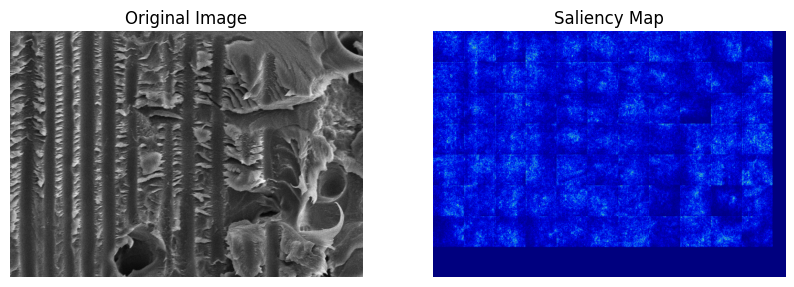

Processing Images: 100%|██████████| 1/1 [01:47<00:00, 107.75s/it]


In [26]:
# Define sliding window parameters
window_size = 224
stride = 224  # Overlapping patches
image_files = sorted(os.listdir(image_folder))[:1]

for filename in tqdm(image_files, desc="Processing Images"):
    image_path = os.path.join(image_folder, filename)
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    cropped_image = image[:int(image.shape[0] * 0.93), :]

    h, w = cropped_image.shape
    saliency_map = np.zeros_like(cropped_image, dtype=np.float32)
    count_map = np.zeros_like(cropped_image, dtype=np.float32)

    # Sliding window processing
    for y in range(0, h - window_size + 1, stride):
        for x in range(0, w - window_size + 1, stride):
            patch = cropped_image[y:y+window_size, x:x+window_size]
            patch = np.stack([patch] * 3, axis=-1)  # Convert to 3-channel
            image_tensor = tf.convert_to_tensor(patch, dtype=tf.float32)
            image_tensor = tf.expand_dims(image_tensor, axis=0)  # Add batch dimension

            patch_saliency = compute_saliency_map(base_model, image_tensor)
            patch_saliency = (patch_saliency - np.min(patch_saliency)) / (np.max(patch_saliency) - np.min(patch_saliency))

            saliency_map[y:y+window_size, x:x+window_size] += patch_saliency
            count_map[y:y+window_size, x:x+window_size] += 1

    saliency_map /= np.maximum(count_map, 1)  # Normalize by count

    # Plot Original Image and Saliency Map
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(cropped_image, cmap="gray")
    ax[0].set_title("Original Image")
    ax[0].axis("off")

    ax[1].imshow(saliency_map, cmap="jet")
    ax[1].set_title("Saliency Map")
    ax[1].axis("off")

    plt.show()

Processing Images:   0%|          | 0/1 [00:00<?, ?it/s]

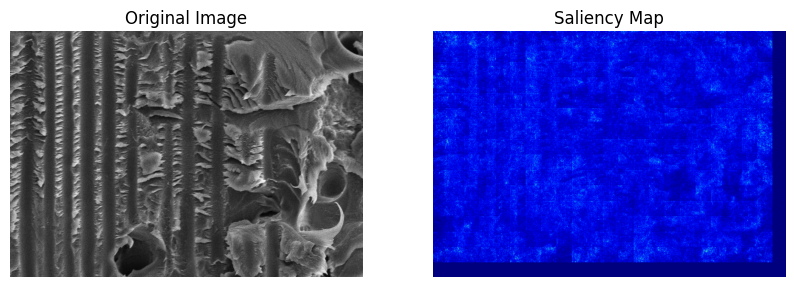

Processing Images: 100%|██████████| 1/1 [06:36<00:00, 396.40s/it]


In [27]:
window_size = 224
stride = 112  # Overlapping patches
image_files = sorted(os.listdir(image_folder))[:1]

for filename in tqdm(image_files, desc="Processing Images"):
    image_path = os.path.join(image_folder, filename)
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    cropped_image = image[:int(image.shape[0] * 0.93), :]

    h, w = cropped_image.shape
    saliency_map = np.zeros_like(cropped_image, dtype=np.float32)
    count_map = np.zeros_like(cropped_image, dtype=np.float32)

    # Sliding window processing
    for y in range(0, h - window_size + 1, stride):
        for x in range(0, w - window_size + 1, stride):
            patch = cropped_image[y:y+window_size, x:x+window_size]
            patch = np.stack([patch] * 3, axis=-1)  # Convert to 3-channel
            image_tensor = tf.convert_to_tensor(patch, dtype=tf.float32)
            image_tensor = tf.expand_dims(image_tensor, axis=0)  # Add batch dimension

            patch_saliency = compute_saliency_map(base_model, image_tensor)
            patch_saliency = (patch_saliency - np.min(patch_saliency)) / (np.max(patch_saliency) - np.min(patch_saliency))

            saliency_map[y:y+window_size, x:x+window_size] += patch_saliency
            count_map[y:y+window_size, x:x+window_size] += 1

    saliency_map /= np.maximum(count_map, 1)  # Normalize by count

    # Plot Original Image and Saliency Map
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(cropped_image, cmap="gray")
    ax[0].set_title("Original Image")
    ax[0].axis("off")

    ax[1].imshow(saliency_map, cmap="jet")
    ax[1].set_title("Saliency Map")
    ax[1].axis("off")

    plt.show()

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Define folders
input_folder = '/Users/rfalcao/Documents/Separated Clear Cusps'  # Folder with images
output_folder = "/Users/rfalcao/Documents/FirstTrainPass"  # Folder to save results
os.makedirs(output_folder, exist_ok=True)

# Custom Dataset Class
class ImageDataset(Dataset):
    def __init__(self, folder, transform=None):
        self.folder = folder
        self.image_files = [os.path.join(folder, f) for f in os.listdir(folder) if f.lower().endswith(('.png', '.jpg', '.tif'))]
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_path = self.image_files[idx]
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, 0  # Dummy label (replace with actual labels if available)

# Preprocessing for ResNet
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to ResNet input size
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize for ResNet
])

# Load dataset
dataset = ImageDataset(input_folder, transform=transform)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

# Load pre-trained ResNet18
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 1)  # Replace final layer for binary classification (adjust as needed)
model = model.to('cuda' if torch.cuda.is_available() else 'cpu')

# Define loss and optimizer
criterion = nn.BCEWithLogitsLoss()  # Binary cross-entropy loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, _ in dataloader:
        inputs = inputs.to('cuda' if torch.cuda.is_available() else 'cpu')
        labels = torch.zeros(inputs.size(0), 1).float().to('cuda' if torch.cuda.is_available() else 'cpu')  # Dummy labels

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(dataloader)}")

# Function to generate saliency maps
def generate_saliency_map(image, model):
    model.eval()
    image = image.unsqueeze(0).to('cuda' if torch.cuda.is_available() else 'cpu')
    image.requires_grad_()

    output = model(image)
    output_idx = output.argmax()
    output_max = output[0, output_idx]

    output_max.backward()
    saliency, _ = torch.max(image.grad.data.abs(), dim=1)
    saliency = saliency.squeeze().cpu().numpy()

    return saliency

# Function to plot saliency maps
def plot_saliency_map(image, saliency):
    image = image.squeeze().permute(1, 2, 0).cpu().numpy()
    image = (image - image.min()) / (image.max() - image.min())  # Normalize image

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(saliency, cmap='hot')
    plt.title("Saliency Map")
    plt.axis('off')

    plt.show()

# Generate and plot saliency maps for a few images
model.eval()
for i, (image, _) in enumerate(dataloader):
    if i >= 3:  # Plot saliency maps for the first 3 images
        break
    saliency = generate_saliency_map(image[0], model)
    plot_saliency_map(image[0], saliency)